# King County Housing Analysis

---

**Import Necessary Libraries**

In [1]:
#data cleaning and stats
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#normality check
import scipy.stats as stats
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf


#linear regression (sklearn and statsmodels)
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols

#model evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from math import sqrt
from functions import linreg_summary, ols_linreg_summary, k_folds_cv, normality_check
from sklearn.model_selection import cross_val_score

#calculations
from haversine import haversine, Unit

---

## Data Understanding

In [2]:
df = pd.read_csv('data/kingcounty.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
#inspect data types and total value counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


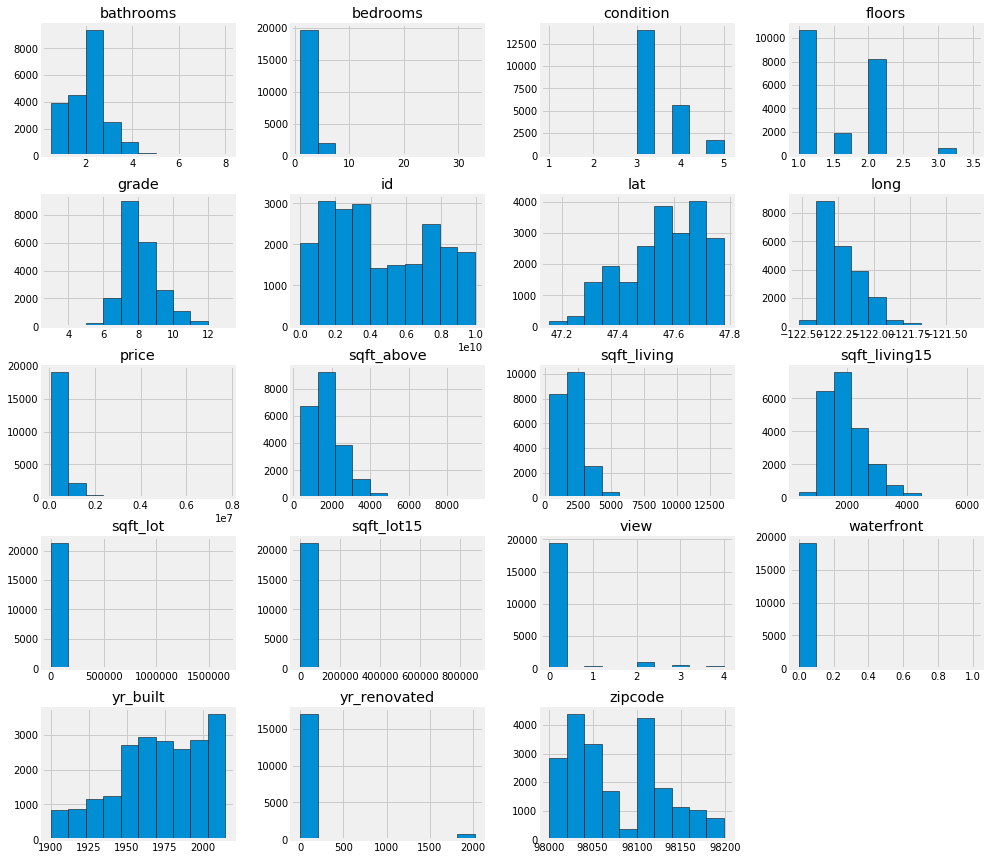

In [4]:
#distribution visualization
df.hist(figsize=(15,15), edgecolor = 'black');

In [5]:
#inspect for any columns with null values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

**Initial data analysis:**
- 'waterfront', 'view', and 'yr_renovated' have null values
- 'yr_renovated' also has a significant amount of missing values represented with a placeholder value 0
- several variables have non-normal distributions, including target variable 'price'
- several variables are categorical variables
- variance in magnitudes of several variable values 

In [6]:
#display value count of placeholder value 
df['yr_renovated'].value_counts() 

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
2000.0       29
2005.0       29
1990.0       22
2004.0       22
2009.0       21
1989.0       20
2006.0       20
2002.0       17
1991.0       16
1998.0       16
1984.0       16
1999.0       15
2008.0       15
2010.0       15
2001.0       15
1983.0       15
2015.0       14
1985.0       14
1986.0       14
1987.0       14
1994.0       14
1992.0       13
1993.0       12
1997.0       12
1995.0       12
          ...  
1975.0        5
1964.0        5
1969.0        4
1963.0        4
1973.0        4
1981.0        4
1965.0        4
1978.0        3
1960.0        3
1958.0        3
1956.0        3
1955.0        3
1945.0        3
1972.0        3
1967.0        2
1957.0        2
1940.0        2
1974.0        2
1962.0        2
1953.0        1
1950.0        1
1934.0        1
1944.0        1
1976.0        1
1948.0        1
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Leng

In [7]:
#display percentage of column with null values
waterfront_perc_missing = round((df['waterfront'].isna().sum()/len(df['waterfront']))*100, 2)
view_perc_missing = round((df['view'].isna().sum()/len(df.view))*100, 2)
yr_renovated_perc_missing = round((df['yr_renovated'].isna().sum()/len(df['yr_renovated']))*100, 2)
yr_renovated_totalperc_missing = round(((df['yr_renovated'].isna().sum()+17011)/
                                        len(df['yr_renovated']))*100, 2)

print(f"'waterfront' null percentage: {waterfront_perc_missing}")
print(f"'view' null percentage: {view_perc_missing}")
print(f"'yr_renovated' null percentage: {yr_renovated_perc_missing}")
print(f"'yr_renovated' null + placeholder values: {yr_renovated_totalperc_missing}")

'waterfront' null percentage: 11.0
'view' null percentage: 0.29
'yr_renovated' null percentage: 17.79
'yr_renovated' null + placeholder values: 96.56


---

## Data Preparation

1. Drop 'yr_renovated' column because 96.56% of its data is missing.
2. Replace null values in 'waterfront' with the most common value since the value counts are significantly different.
3. Drop rows with missing values for 'view' column since it is only 0.29% of the dataset.
4. Conduct further data analysis.

In [8]:
df = df.drop('yr_renovated', axis=1)

# replace null values in "waterfront" with most common value 0
df['waterfront'] = df['waterfront'].fillna(0)

# drop null values in 'view' column
df = df.dropna(subset=['view'])

In [9]:
#sanity check
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 20 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_above       21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
zipcode          21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
dtypes: float64(7), int64(11), object(2)
memory usage: 3.5+ MB


---

**Further data inspection**

In [11]:
#after further inspection, I've discovered another placeholder value '?'
df['sqft_basement'].value_counts().head()

0.0      12798
?          452
600.0      216
500.0      209
700.0      207
Name: sqft_basement, dtype: int64

In [12]:
#replace '?' values with difference in sqft_living and sqft_above
df.loc[df['sqft_basement'] == '?', 'sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [13]:
#change data type to float
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: float(x))

In [14]:
#drop 'id' column because it is not a predictor
#drop 'date' for now 
df = df.drop(df[['id', 'date']], axis=1)

In [15]:
#change 'yr_built' column to 'age' of house column
df['age'] = df['yr_built'].apply(lambda x: 2019 - x)
df = df.drop(['yr_built'], axis=1)

In [16]:
#change view column to a binary column
#due to large difference in value counts
df['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [17]:
df['view'] = df['view'].apply(lambda x: 1 if x > 0 else 0)
df['view'].value_counts()

0    19422
1     2112
Name: view, dtype: int64

**Transform categorical columns for use in Linear Regression model**

In [18]:
# #transform categorical column 'waterfront'
# waterfront_dummies = pd.get_dummies(df["waterfront"], 
#                                     prefix="waterfront", 
#                                     drop_first=True,
#                                    dtype=int)
# df = df.drop(["waterfront"], axis=1)
# df = pd.concat([df, waterfront_dummies], axis=1)

In [19]:
# #transform categorical column 'view'
# view_dummies = pd.get_dummies(df["view"], 
#                                     prefix="view", 
#                                     drop_first=True,
#                                    dtype=int)
# df = df.drop(["view"], axis=1)
# df = pd.concat([df, view_dummies], axis=1)

---

### Correlation Visualization

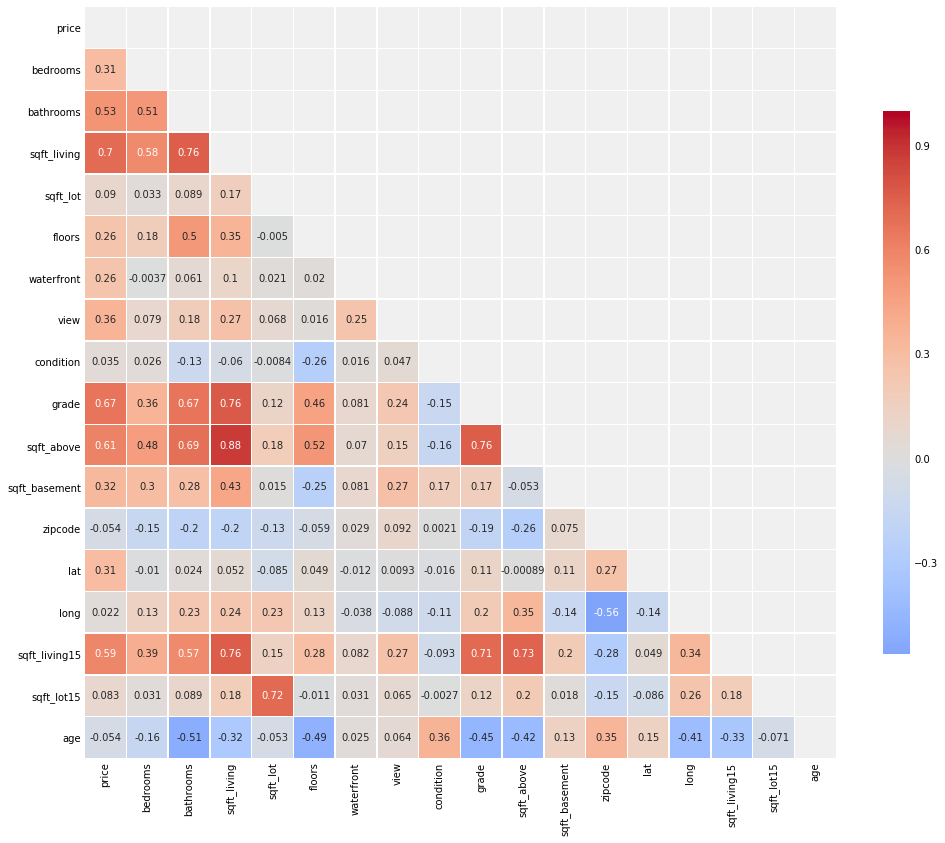

In [20]:
#visualize correlation using heatmap
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

**For my first model, I will start with variables that are positively correlated with the target variable.**

In [21]:
# create df for first model by dropping variables not positively correlated with 'price'
df_1 = df.drop(df[['zipcode', 'age']], axis=1)

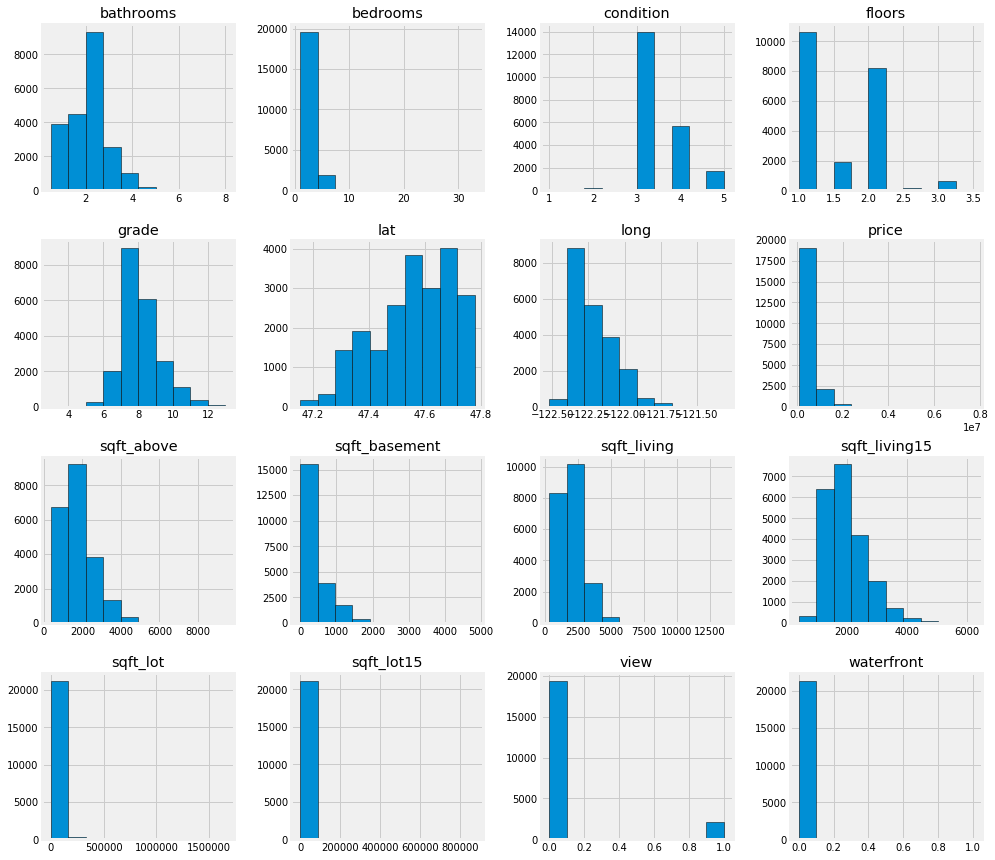

In [22]:
#let's take a look of distributions of selected predictors after preliminary data preparation
df_1.hist(figsize=(15,15), edgecolor = 'black');

---

## Linear Regression Assumption checks <br/>
1. Linearity 
2. Normality (residuals) 
3. Homoscedasticity

bedrooms
[('Jarque-Bera', 1154426.555294989), ('Prob', 0.0), ('Skew', 3.8582623896076913), ('Kurtosis', 38.02974136062947)]
Redisuals MIN: -3506465.56
Redisuals MAX: 6840169.54


<Figure size 432x288 with 0 Axes>

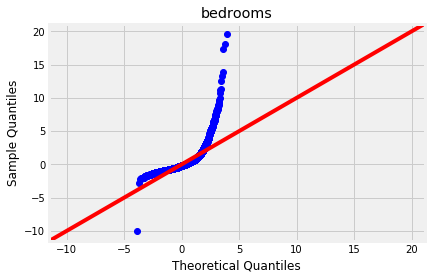

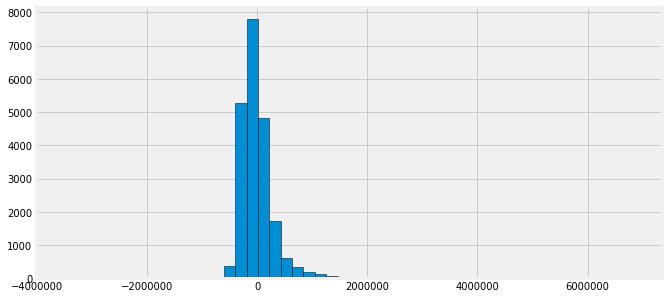

bathrooms
[('Jarque-Bera', 857836.5578051317), ('Prob', 0.0), ('Skew', 3.4214714269944073), ('Kurtosis', 33.15372611067674)]
Redisuals MIN: -1436480.23
Redisuals MAX: 5923715.15


<Figure size 432x288 with 0 Axes>

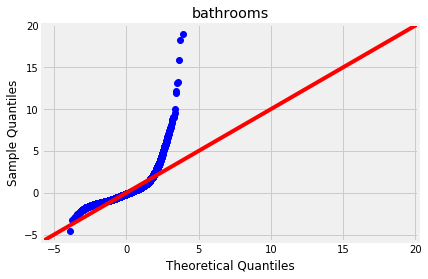

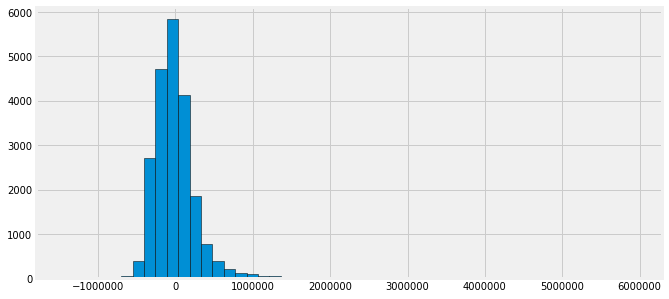

sqft_living
[('Jarque-Bera', 516142.2885372242), ('Prob', 0.0), ('Skew', 2.7805452866970697), ('Kurtosis', 26.330739573364625)]
Redisuals MIN: -1468127.9
Redisuals MAX: 4368970.96


<Figure size 432x288 with 0 Axes>

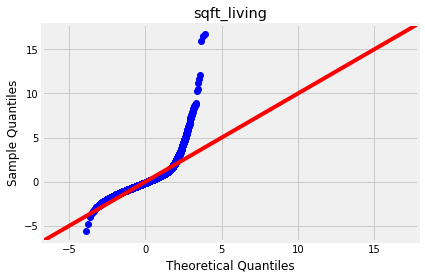

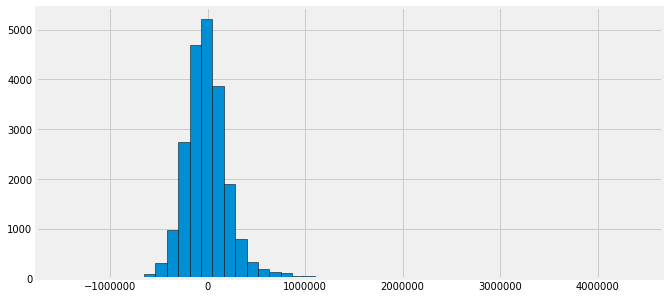

sqft_lot
[('Jarque-Bera', 1100648.8107874435), ('Prob', 0.0), ('Skew', 3.980227256085205), ('Kurtosis', 37.10751399055717)]
Redisuals MIN: -1268845.38
Redisuals MAX: 7149945.42


<Figure size 432x288 with 0 Axes>

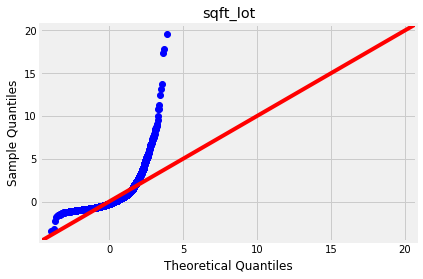

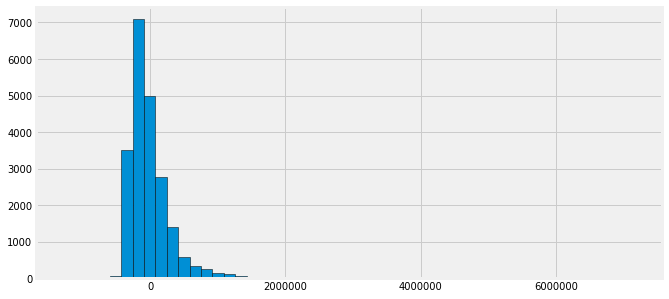

floors
[('Jarque-Bera', 1204740.126098323), ('Prob', 0.0), ('Skew', 4.025791667062309), ('Kurtosis', 38.747375414917116)]
Redisuals MIN: -597554.53
Redisuals MAX: 6984603.09


<Figure size 432x288 with 0 Axes>

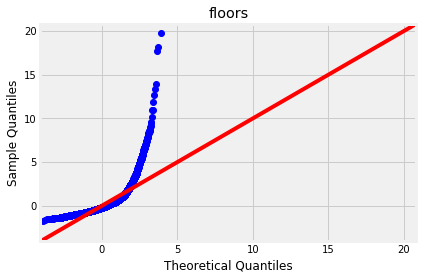

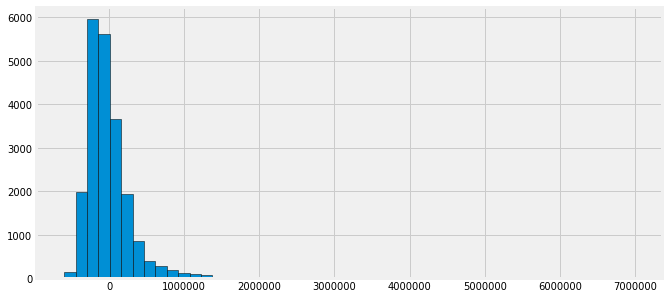

waterfront
[('Jarque-Bera', 905012.3579128587), ('Prob', 0.0), ('Skew', 3.5956892320797853), ('Kurtosis', 33.934371698271846)]
Redisuals MIN: -1407505.86
Redisuals MAX: 7167755.0


<Figure size 432x288 with 0 Axes>

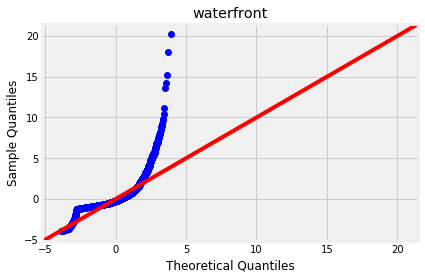

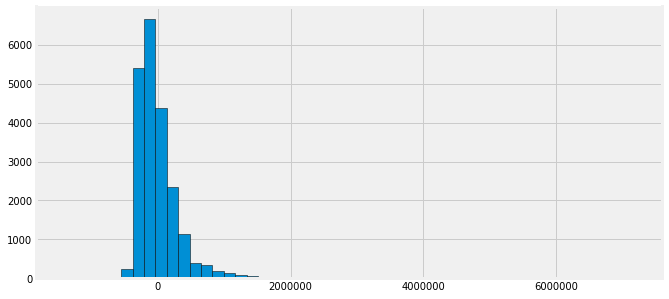

view
[('Jarque-Bera', 1066450.6026527975), ('Prob', 0.0), ('Skew', 3.709010344649262), ('Kurtosis', 36.66823199680558)]
Redisuals MIN: -783800.34
Redisuals MAX: 6762199.66


<Figure size 432x288 with 0 Axes>

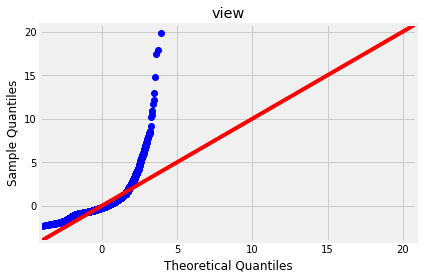

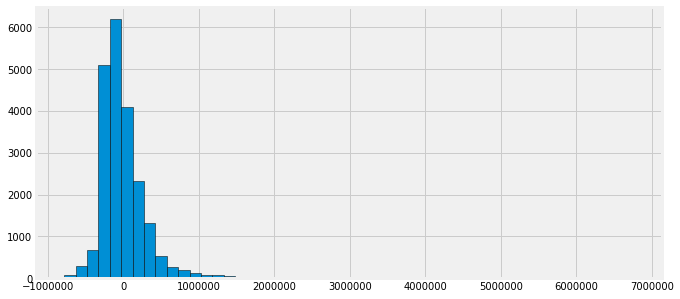

condition
[('Jarque-Bera', 1090709.5200926769), ('Prob', 0.0), ('Skew', 3.976475082304317), ('Kurtosis', 36.94649357560285)]
Redisuals MIN: -462811.35
Redisuals MAX: 7148188.65


<Figure size 432x288 with 0 Axes>

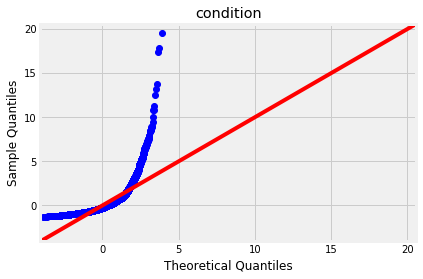

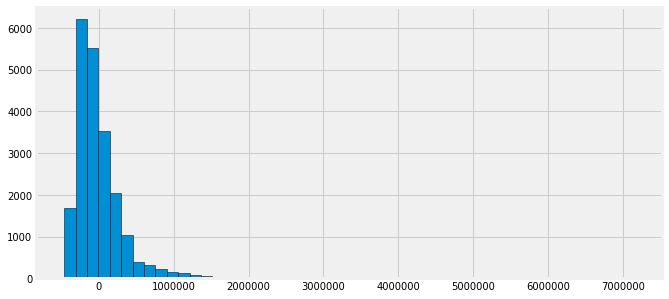

grade
[('Jarque-Bera', 1970129.654682018), ('Prob', 0.0), ('Skew', 4.0217372633227315), ('Kurtosis', 49.16323948064056)]
Redisuals MIN: -817395.74
Redisuals MAX: 6045358.17


<Figure size 432x288 with 0 Axes>

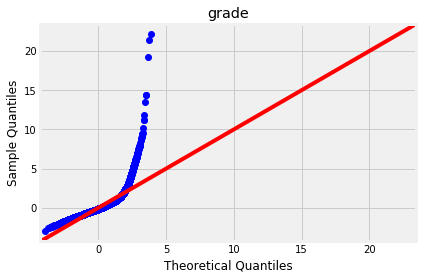

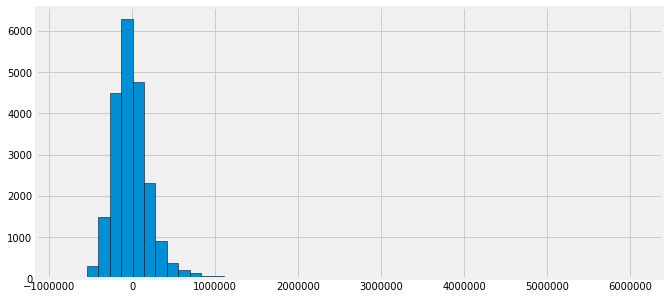

sqft_above
[('Jarque-Bera', 685308.2436162458), ('Prob', 0.0), ('Skew', 3.2120260867558423), ('Kurtosis', 29.87971265694378)]
Redisuals MIN: -910814.43
Redisuals MAX: 5343459.99


<Figure size 432x288 with 0 Axes>

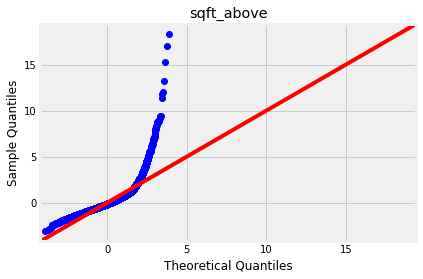

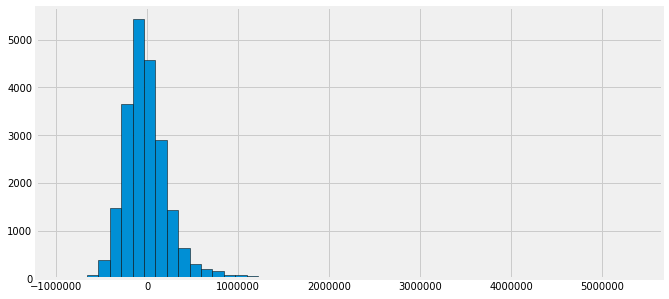

sqft_basement
[('Jarque-Bera', 862520.9799034009), ('Prob', 0.0), ('Skew', 3.662561182252118), ('Kurtosis', 33.12700638454822)]
Redisuals MIN: -599262.83
Redisuals MAX: 6310450.84


<Figure size 432x288 with 0 Axes>

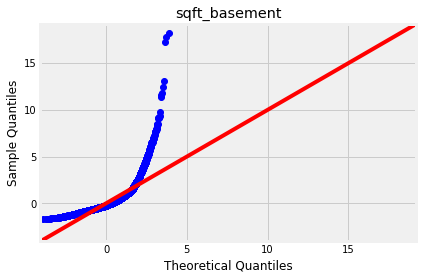

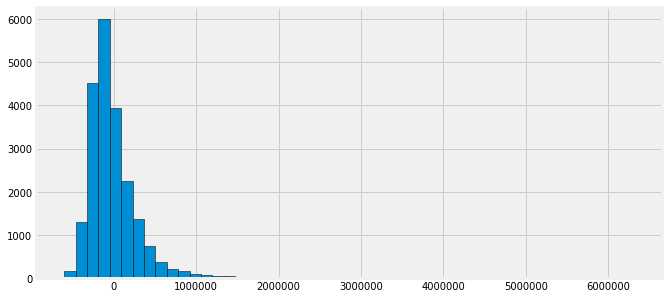

lat
[('Jarque-Bera', 1448276.0977329141), ('Prob', 0.0), ('Skew', 4.311189020834662), ('Kurtosis', 42.24006011692289)]
Redisuals MIN: -592362.2
Redisuals MAX: 7103303.49


<Figure size 432x288 with 0 Axes>

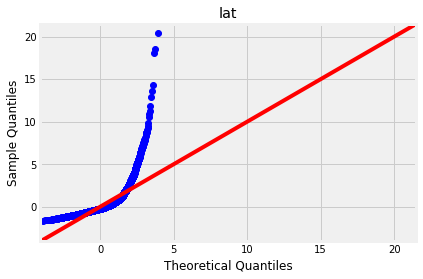

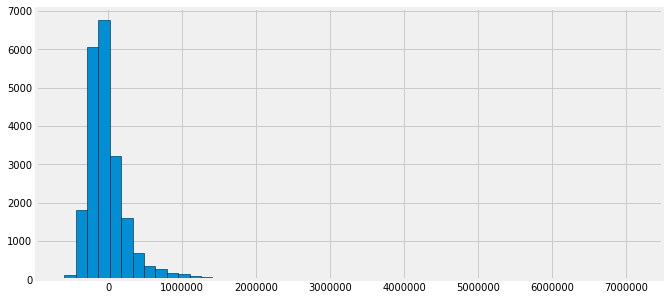

long
[('Jarque-Bera', 1091279.7026092964), ('Prob', 0.0), ('Skew', 3.983358920169944), ('Kurtosis', 36.95262474565273)]
Redisuals MIN: -477838.39
Redisuals MAX: 7166300.84


<Figure size 432x288 with 0 Axes>

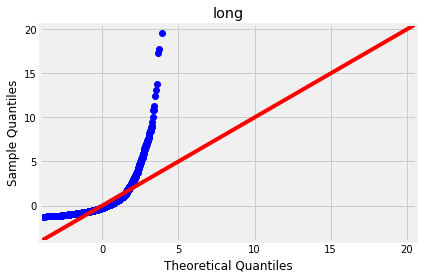

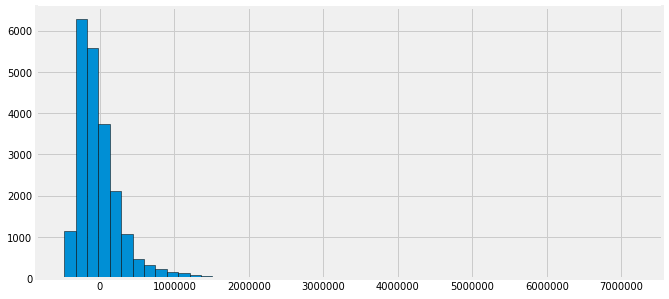

sqft_living15
[('Jarque-Bera', 1851998.0343238688), ('Prob', 0.0), ('Skew', 4.158335538283399), ('Kurtosis', 47.66447687688195)]
Redisuals MIN: -841003.88
Redisuals MAX: 6548967.03


<Figure size 432x288 with 0 Axes>

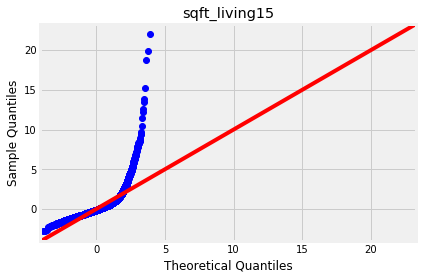

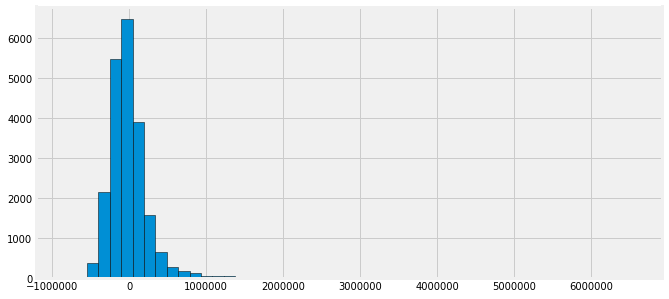

sqft_lot15
[('Jarque-Bera', 1095785.8109524415), ('Prob', 0.0), ('Skew', 3.977550644108034), ('Kurtosis', 37.0292200353399)]
Redisuals MIN: -783833.78
Redisuals MAX: 7164356.84


<Figure size 432x288 with 0 Axes>

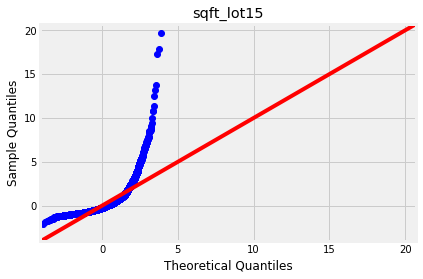

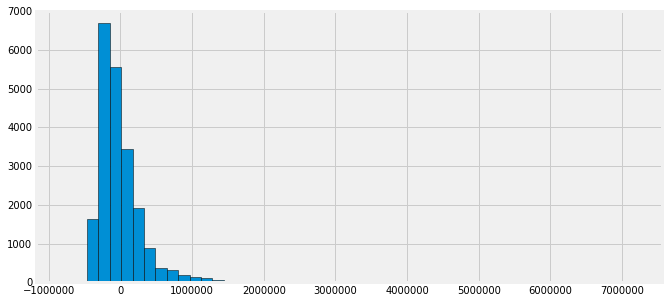

In [23]:
#Conduct normality check
normality_check(df_1)

**Observations:**
1. Based off the qq-plots and histograms, the residuals for all independent variables do not have normal distributions.
2. QQ-plots display an obvious positive skew for all independent variables and can be confirmed with its corresponding histograms.
3. Residuals max is much higher then residuals min.
4. Jarque-Bera score is incredibly high for all independent variables, indicating a non-normal distribution.
5. Skew measure is high indicating positive skewness.
5. Kurtosis for all independent variables are also high, indicating heavy tails.

**Notes**
- Jarque-Bera score roughly above 5 indicates residuals are not-normally distributed.
- Skewness lower than -1 or higher than 1 indicates high skewness.
- Kurtosis higher than 3 indicates heavier tails than a normal distribution.

**Analyze target variable ('price')**

In [24]:
df['price'].describe()

count    2.153400e+04
mean     5.400577e+05
std      3.660596e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [25]:
#check difference between mean and median, difference signifies outliers
print(df.price.mean())
print(df.price.median())

540057.663833937
450000.0


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


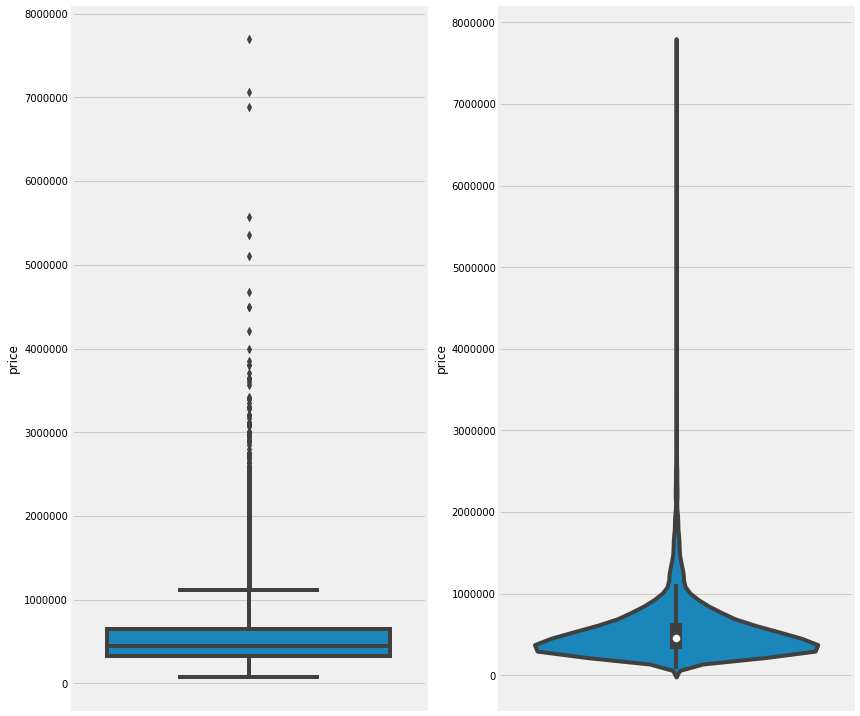

In [26]:
#plot boxplot and violin plot to display the distributions of the data
f, axes = plt.subplots(1, 2, figsize=(12,10))
sns.boxplot(y=df.price, ax=axes[0])
sns.violinplot(y=df.price, ax=axes[1])
plt.tight_layout(pad=0.9)

**I will conduct a log-transformation on target variable 'price' and check normality of residuals**

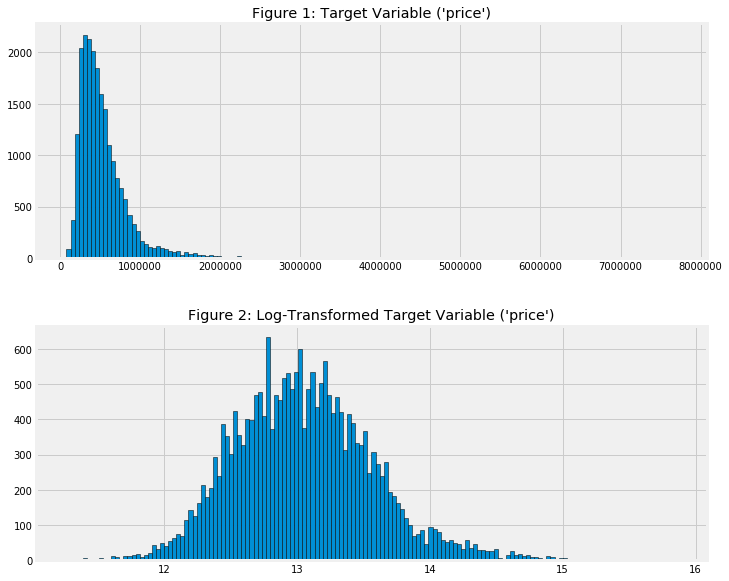

In [27]:
X_log = np.log(df_1['price'])
X = df_1['price']

fig, ax = plt.subplots(2, 1, figsize=(10,8))
fig.tight_layout(h_pad=5)
grid = plt.GridSpec(2, 1, hspace=10)

ax[0].hist(X, bins=150, edgecolor = 'black')
ax[0].set_title("Figure 1: Target Variable ('price')")
ax[1].hist(X_log, bins=150, edgecolor = 'black')
ax[1].set_title("Figure 2: Log-Transformed Target Variable ('price')")
plt.show()

bedrooms
[('Jarque-Bera', 1453.2305810130351), ('Prob', 0.0), ('Skew', 0.2895224161980989), ('Kurtosis', 4.133294602873283)]
Redisuals MIN: -5.45
Redisuals MAX: 2.41


<Figure size 432x288 with 0 Axes>

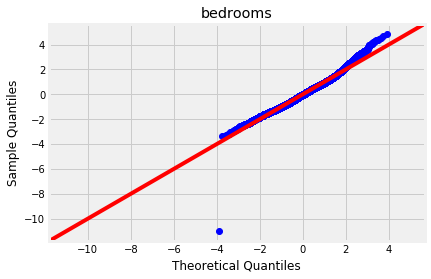

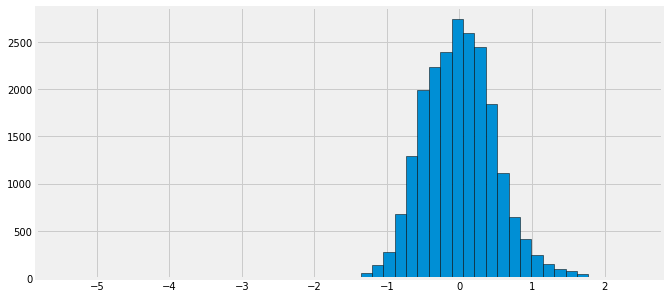

bathrooms
[('Jarque-Bera', 198.31571367687943), ('Prob', 8.635548700008987e-44), ('Skew', 0.23267251086321222), ('Kurtosis', 3.066934007883188)]
Redisuals MIN: -2.06
Redisuals MAX: 2.09


<Figure size 432x288 with 0 Axes>

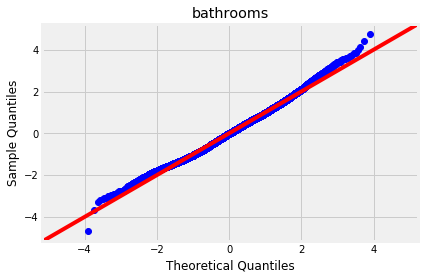

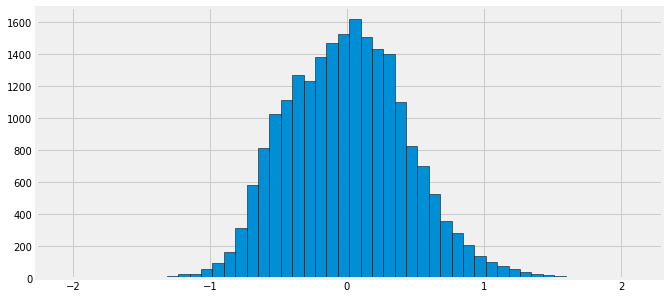

sqft_living
[('Jarque-Bera', 3.6902758157188464), ('Prob', 0.15800352945854856), ('Skew', 0.029200586074116436), ('Kurtosis', 2.9735013836714903)]
Redisuals MIN: -2.98
Redisuals MAX: 1.28


<Figure size 432x288 with 0 Axes>

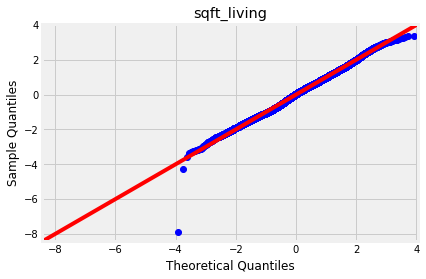

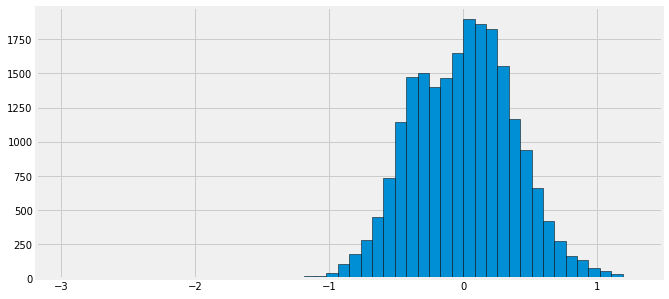

sqft_lot
[('Jarque-Bera', 1080.7913482180995), ('Prob', 2.0377020860479333e-235), ('Skew', 0.42224043729281535), ('Kurtosis', 3.701007794447613)]
Redisuals MIN: -2.36
Redisuals MAX: 2.79


<Figure size 432x288 with 0 Axes>

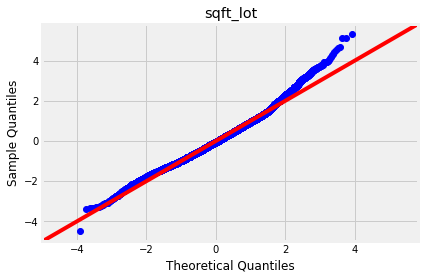

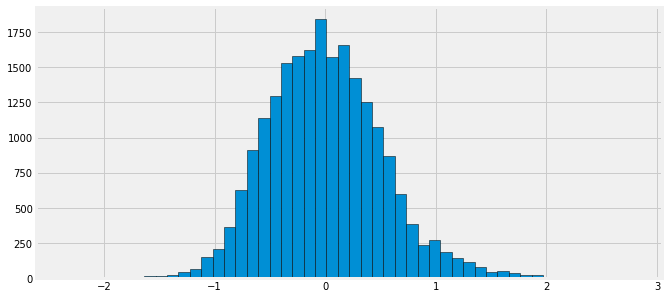

floors
[('Jarque-Bera', 1009.6642048716487), ('Prob', 5.678107683240074e-220), ('Skew', 0.43444103960770053), ('Kurtosis', 3.6085486236935074)]
Redisuals MIN: -1.79
Redisuals MAX: 2.57


<Figure size 432x288 with 0 Axes>

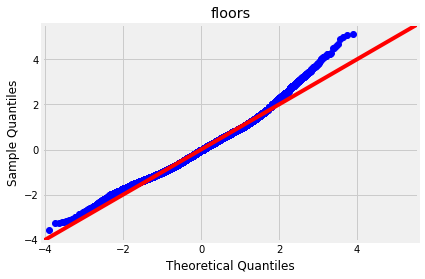

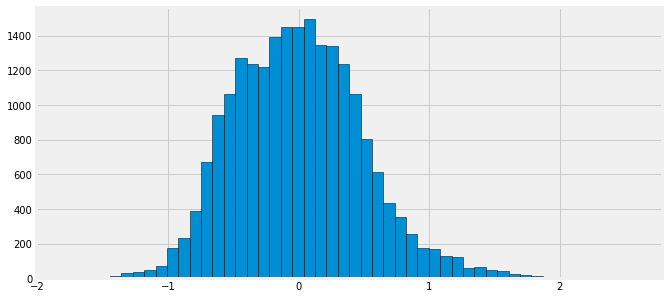

waterfront
[('Jarque-Bera', 701.9681659498474), ('Prob', 3.7115005403566824e-153), ('Skew', 0.3566532956159612), ('Kurtosis', 3.523018991423048)]
Redisuals MIN: -1.78
Redisuals MAX: 2.82


<Figure size 432x288 with 0 Axes>

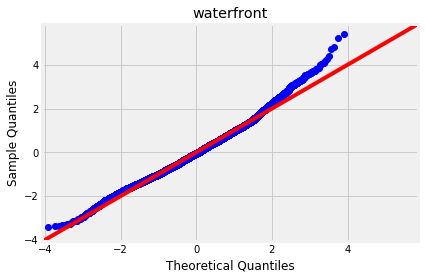

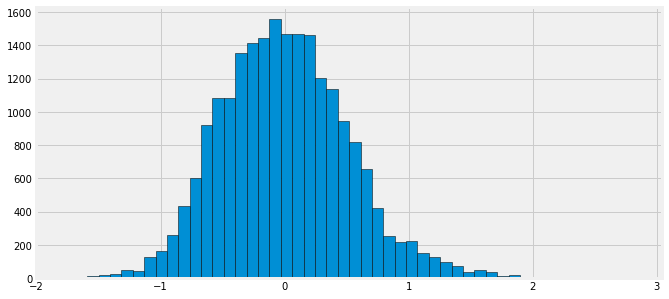

view
[('Jarque-Bera', 439.1203782051602), ('Prob', 4.428140856928659e-96), ('Skew', 0.27660653753908937), ('Kurtosis', 3.4282081678348164)]
Redisuals MIN: -1.73
Redisuals MAX: 2.54


<Figure size 432x288 with 0 Axes>

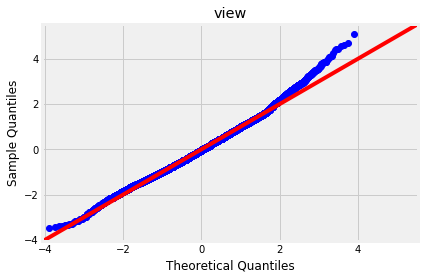

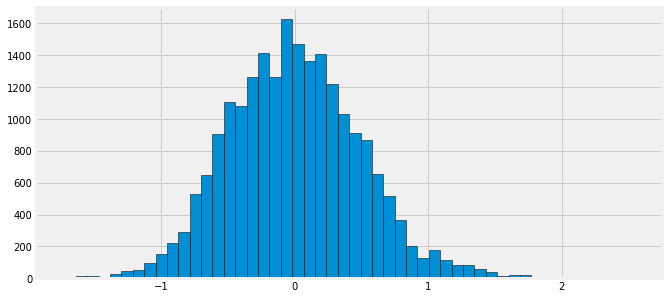

condition
[('Jarque-Bera', 1061.6172589536352), ('Prob', 2.9698962062308685e-231), ('Skew', 0.4264864827576028), ('Kurtosis', 3.6750015964098113)]
Redisuals MIN: -1.72
Redisuals MAX: 2.79


<Figure size 432x288 with 0 Axes>

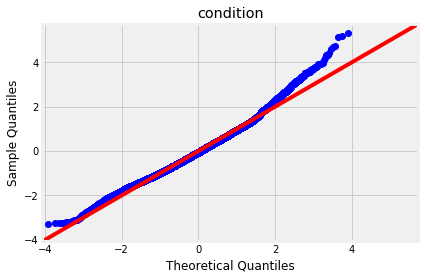

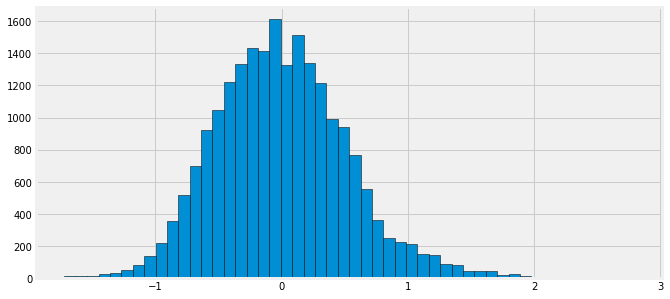

grade
[('Jarque-Bera', 133.75350522975128), ('Prob', 9.032237979159597e-30), ('Skew', 0.18161770213487027), ('Kurtosis', 3.130883689156551)]
Redisuals MIN: -1.43
Redisuals MAX: 1.78


<Figure size 432x288 with 0 Axes>

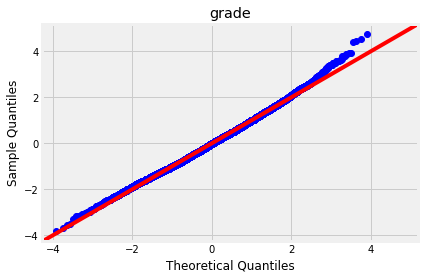

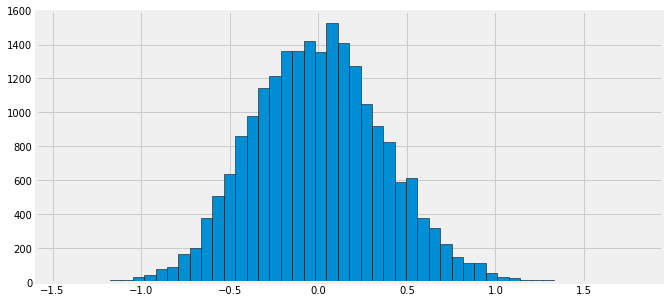

sqft_above
[('Jarque-Bera', 127.49886060941822), ('Prob', 2.0605074741217353e-28), ('Skew', 0.18585723045908747), ('Kurtosis', 2.9373266131043954)]
Redisuals MIN: -1.4
Redisuals MAX: 1.81


<Figure size 432x288 with 0 Axes>

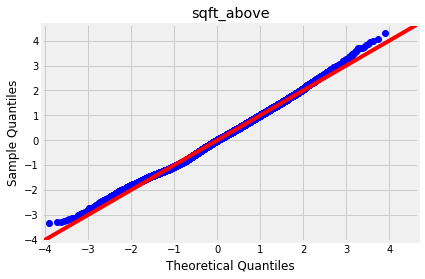

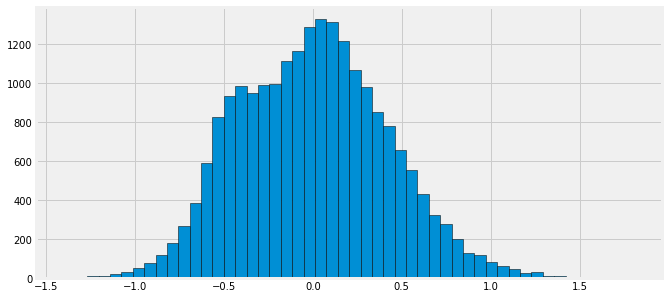

sqft_basement
[('Jarque-Bera', 692.2078564936772), ('Prob', 4.886228779733015e-151), ('Skew', 0.37818265577452237), ('Kurtosis', 3.446529559234162)]
Redisuals MIN: -1.67
Redisuals MAX: 2.42


<Figure size 432x288 with 0 Axes>

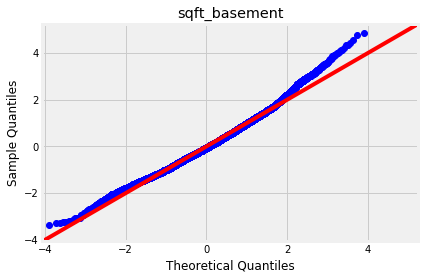

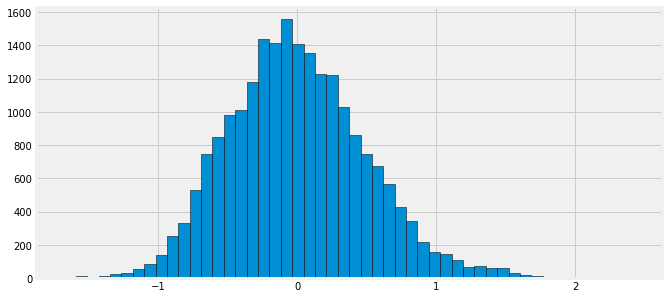

lat
[('Jarque-Bera', 2692.0661776872576), ('Prob', 0.0), ('Skew', 0.5979050600615046), ('Kurtosis', 4.2531522421021215)]
Redisuals MIN: -1.94
Redisuals MAX: 2.69


<Figure size 432x288 with 0 Axes>

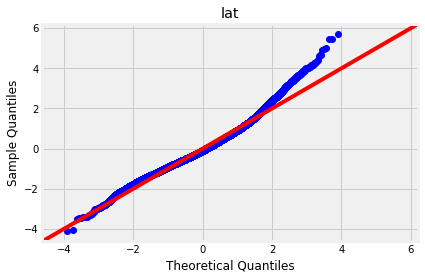

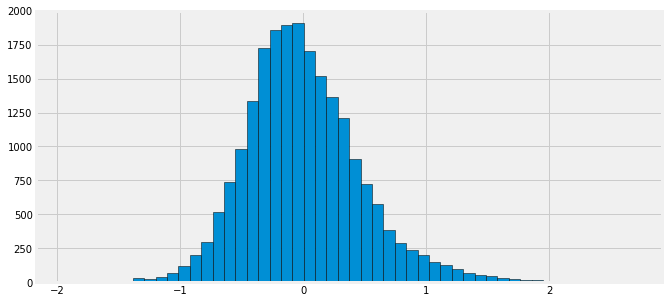

long
[('Jarque-Bera', 1137.4048856151403), ('Prob', 1.036733766503538e-247), ('Skew', 0.4389533352569681), ('Kurtosis', 3.7049372165499244)]
Redisuals MIN: -1.82
Redisuals MAX: 2.83


<Figure size 432x288 with 0 Axes>

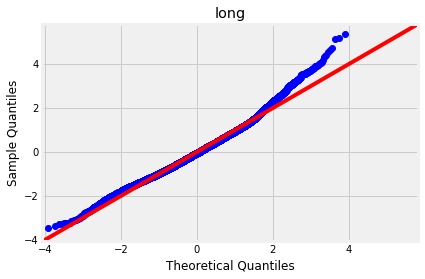

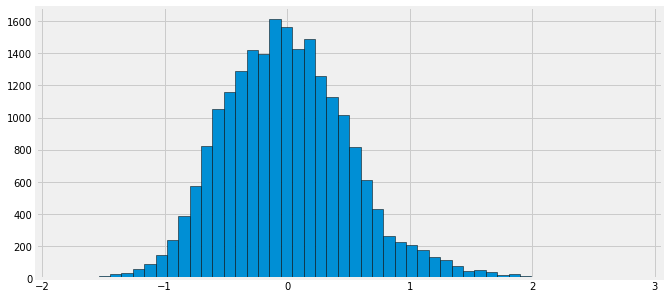

sqft_living15
[('Jarque-Bera', 450.95611239781636), ('Prob', 1.1915832851285467e-98), ('Skew', 0.28616315238965817), ('Kurtosis', 3.4183786135442547)]
Redisuals MIN: -1.89
Redisuals MAX: 1.95


<Figure size 432x288 with 0 Axes>

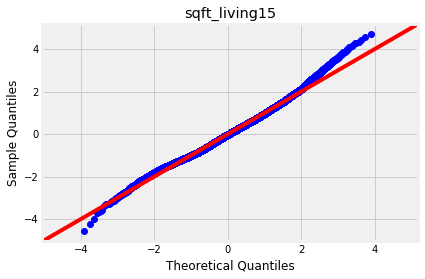

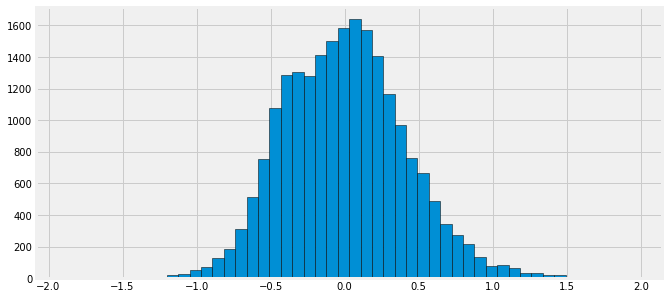

sqft_lot15
[('Jarque-Bera', 1060.978592042642), ('Prob', 4.0872013130914044e-231), ('Skew', 0.4239161690531834), ('Kurtosis', 3.680924780468658)]
Redisuals MIN: -1.81
Redisuals MAX: 2.82


<Figure size 432x288 with 0 Axes>

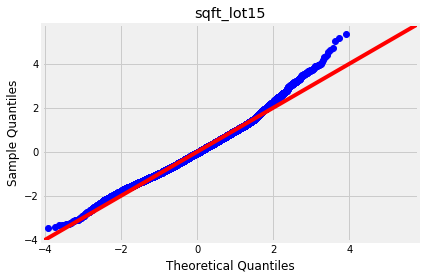

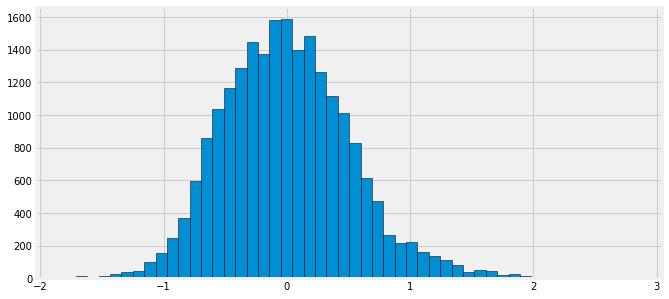

In [28]:
# Normality check using log transformation of target variable 'price'
#Create df with log-transformed 'price'
df_2 = df_1.drop(['price'], axis=1)
df_2['price'] = np.log(df['price'])

#conduct normality check
normality_check(df_2)

**Observations:**
1. By log-transforming the target variable 'price, Jarque-Bera, Skew, and Kurtosis have all gone down significantly.

---

## Initial Multiple Linear Regression Model

**Initial model with all variables positively correlated with target ('price')**

In [29]:
#sklearn linear regression
linreg_summary(df_2)

R^2: 0.7526635901839903
MSE: 0.06895215406675555
RMSE: 0.2625874217603645
MAE: 0.20460839711393647
TRAIN_MAE: 0.2053484074003271


**Not a big difference between test MAE and TRAIN MAE which is good.** <br/>
**A big difference is an indication overfitting.**

CV 5-Fold MAE: 0.20558546279250783
CV 10-Fold MAE: 0.20556690239015327
CV 20-Fold MAE: 0.205456664046859


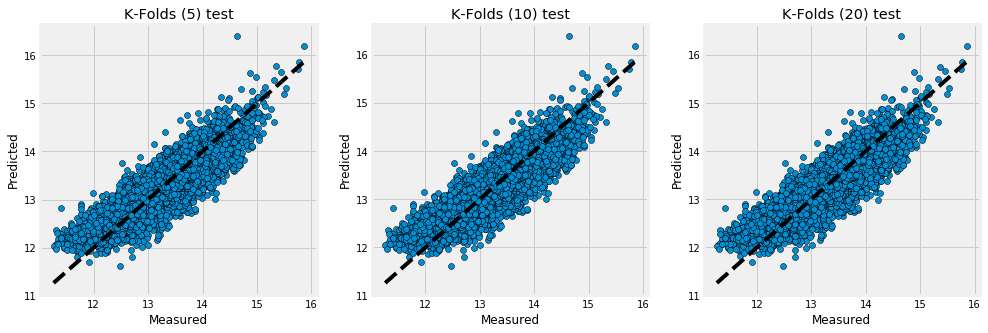

In [30]:
#conduct k-folds cross validation and a visualization of obtained predictions 
k_folds_cv(df_2)

In [31]:
#statsmodels OLS version to see p_values and adjusted R^2
ols_linreg_summary(df_2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     4595.
Date:                Sat, 09 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:54:01   Log-Likelihood:                -1834.6
No. Observations:               21534   AIC:                             3699.
Df Residuals:                   21519   BIC:                             3819.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -87.6215      1.850    -47.369      0.000     -91.247     -83.996
bedrooms         -0.0061      0.002     -2.472      0.013      -0.011      -0.001
bathrooms         0.0239      0.004      5.928      0.000       0.016       0.032
sqft_living       0.0001   2.94e-06     38.659      0.000       0.000       0.000
sqft_lot       5.616e-07   6.27e-08      8.951      0.000    4.39e-07    6.85e-07
floors            0.0346      0.005      7.514      0.000       0.026       0.044
waterfront        0.4840      0.023     21.270      0.000       0.439       0.529
view              0.1771      0.007     26.234      0.000       0.164       0.190
condition         0.0964      0.003     33.200      0.000       0.091       0.102
grade             0.1375      0.003     49.927      0.000       0.132       0.143
sqft_above     5.124e-05   2.94e-06     17.420      0.000    4.55e-05     5.7e-05
sqft_basement  6.237e-05   3.46e-06     18.018      0.000    5.56e-05    6.92e-05
lat               1.4615      0.013    109.019      0.000       1.435       1.488
long             -0.2383      0.015    -16.116      0.000      -0.267      -0.209
sqft_living15     0.0001    4.5e-06     22.587      0.000    9.29e-05       0.000
sqft_lot15    -3.016e-07   9.61e-08     -3.139      0.002    -4.9e-07   -1.13e-07
==============================================================================
Omnibus:                      304.167   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              495.025
Skew:                           0.126   Prob(JB):                    3.21e-108
Kurtosis:                       3.699   Cond. No.                     3.39e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.79e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

---

**Next model:**
1. Remove independent variables with p-value above of 0.05 
2. Remove independent variables that are highly correlated with each other

---

## Multicollinearity Check

**Correlation with an absolute value around 0.7-0.8 or higher is considered a high correlation. <br/>
I will remove independant variables that are highly correlated with each other.**

In [32]:
df_2.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,price
bedrooms,1.000000,0.514368,0.577934,0.032735,0.177391,-0.003733,0.079408,0.026402,0.356095,0.479148,0.302149,-0.010415,0.132318,0.392874,0.030952,0.342790
bathrooms,0.514368,1.000000,0.755277,0.088921,0.502285,0.061115,0.176306,-0.126682,0.665312,0.686173,0.282563,0.024487,0.225025,0.569139,0.088854,0.550788
sqft_living,0.577934,0.755277,1.000000,0.173768,0.353529,0.101982,0.269271,-0.059783,0.762398,0.876553,0.433930,0.052383,0.241856,0.756208,0.184801,0.694786
sqft_lot,0.032735,0.088921,0.173768,1.000000,-0.005025,0.021465,0.068451,-0.008375,0.115122,0.184325,0.015487,-0.085143,0.230137,0.145142,0.717095,0.100142
floors,0.177391,0.502285,0.353529,-0.005025,1.000000,0.020357,0.016316,-0.264138,0.458694,0.523367,-0.246203,0.049419,0.125329,0.279176,-0.010850,0.310492
waterfront,-0.003733,0.061115,0.101982,0.021465,0.020357,1.000000,0.249683,0.016224,0.081195,0.069931,0.080684,-0.012282,-0.037845,0.082352,0.030605,0.169036
view,0.079408,0.176306,0.269271,0.068451,0.016316,0.249683,1.000000,0.046954,0.235883,0.152174,0.273815,0.009319,-0.087788,0.272491,0.065121,0.329825
condition,0.026402,-0.126682,-0.059783,-0.008375,-0.264138,0.016224,0.046954,1.000000,-0.147326,-0.158830,0.173279,-0.015594,-0.105475,-0.093172,-0.002702,0.038400
grade,0.356095,0.665312,0.762398,0.115122,0.458694,0.081195,0.235883,-0.147326,1.000000,0.755977,0.166673,0.113787,0.200821,0.713462,0.121435,0.703402
sqft_above,0.479148,0.686173,0.876553,0.184325,0.523367,0.069931,0.152174,-0.158830,0.755977,1.000000,-0.053268,-0.000889,0.345051,0.731543,0.195413,0.601490


In [33]:
#check to see which independant variables have corraletion greater than 0.8
abs(df_2.corr()) > 0.8

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,price
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
sqft_above,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False


**Independant Variables Highly Correlated with each other (above 0.8)** <br/>
'sqft_living' - 'sqft_above' <br/>

**Correlation to target variable ('price)** <br/>
'sqft_living' (0.694786)<br/>
'sqft_above' (0.601490)

**I will drop 'sqft_above' because 'sqft_living' is more correlated to 'price'.** <br/>
**There are currently no features with a p-value over 0.05 threshold.**

---

## Second Multiple Linear Regression Model

In [34]:
#Create new df for second model
df_3 = df_2.drop(['sqft_above'], axis=1)

In [35]:
linreg_summary(df_3)

R^2: 0.7526635901839824
MSE: 0.06895215406675774
RMSE: 0.2625874217603687
MAE: 0.20460839711393655
TRAIN_MAE: 0.20534840740032329


CV 5-Fold MAE: 0.20558546279250195
CV 10-Fold MAE: 0.2055669023901566
CV 20-Fold MAE: 0.2054566640468583


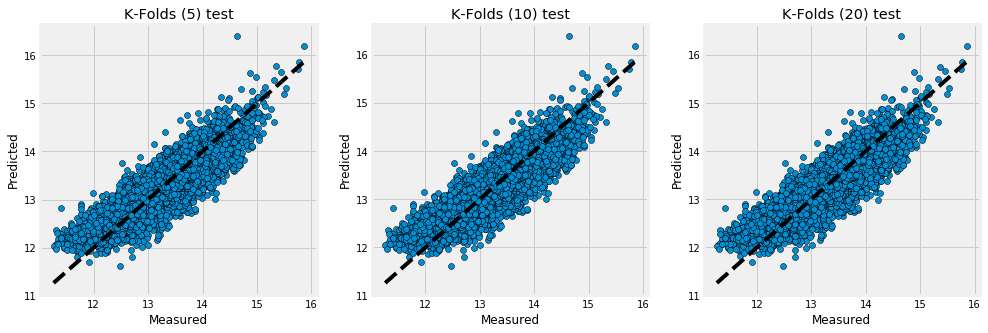

In [36]:
k_folds_cv(df_3)

In [37]:
ols_linreg_summary(df_3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     4595.
Date:                Sat, 09 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:54:38   Log-Likelihood:                -1834.6
No. Observations:               21534   AIC:                             3699.
Df Residuals:                   21519   BIC:                             3819.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -87.6215      1.850    -47.369      0.000     -91.247     -83.996
bedrooms         -0.0061      0.002     -2.472      0.013      -0.011      -0.001
bathrooms         0.0239      0.004      5.928      0.000       0.016       0.032
sqft_living       0.0002   4.75e-06     34.679      0.000       0.000       0.000
sqft_lot       5.616e-07   6.27e-08      8.951      0.000    4.39e-07    6.85e-07
floors            0.0346      0.005      7.514      0.000       0.026       0.044
waterfront        0.4840      0.023     21.270      0.000       0.439       0.529
view              0.1771      0.007     26.234      0.000       0.164       0.190
condition         0.0964      0.003     33.200      0.000       0.091       0.102
grade             0.1375      0.003     49.927      0.000       0.132       0.143
sqft_basement  1.113e-05   5.71e-06      1.948      0.051   -6.66e-08    2.23e-05
lat               1.4615      0.013    109.019      0.000       1.435       1.488
long             -0.2383      0.015    -16.116      0.000      -0.267      -0.209
sqft_living15     0.0001    4.5e-06     22.587      0.000    9.29e-05       0.000
sqft_lot15    -3.016e-07   9.61e-08     -3.139      0.002    -4.9e-07   -1.13e-07
==============================================================================
Omnibus:                      304.167   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              495.025
Skew:                           0.126   Prob(JB):                    3.21e-108
Kurtosis:                       3.699   Cond. No.                     5.20e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

**Next model:**
- Min-max scale features due to variance of value magnitudes
- Conduct SKLearn's Feature Ranking with Recursive Feature Elimination
- Drop 'sqft_basement' because p-value is over 0.05

---

In [38]:
#sqft_basement has a p-value over 0.05
df_3 = df_3.drop('sqft_basement', axis=1)

In [39]:
#conduct min-max scaling
for i in df_3.columns:
    if i == 'price':
        pass
    else:
        df_3[i] = (df_3[i] - df_3[i].min())/(df_3[i].max() - df_3[i].min())

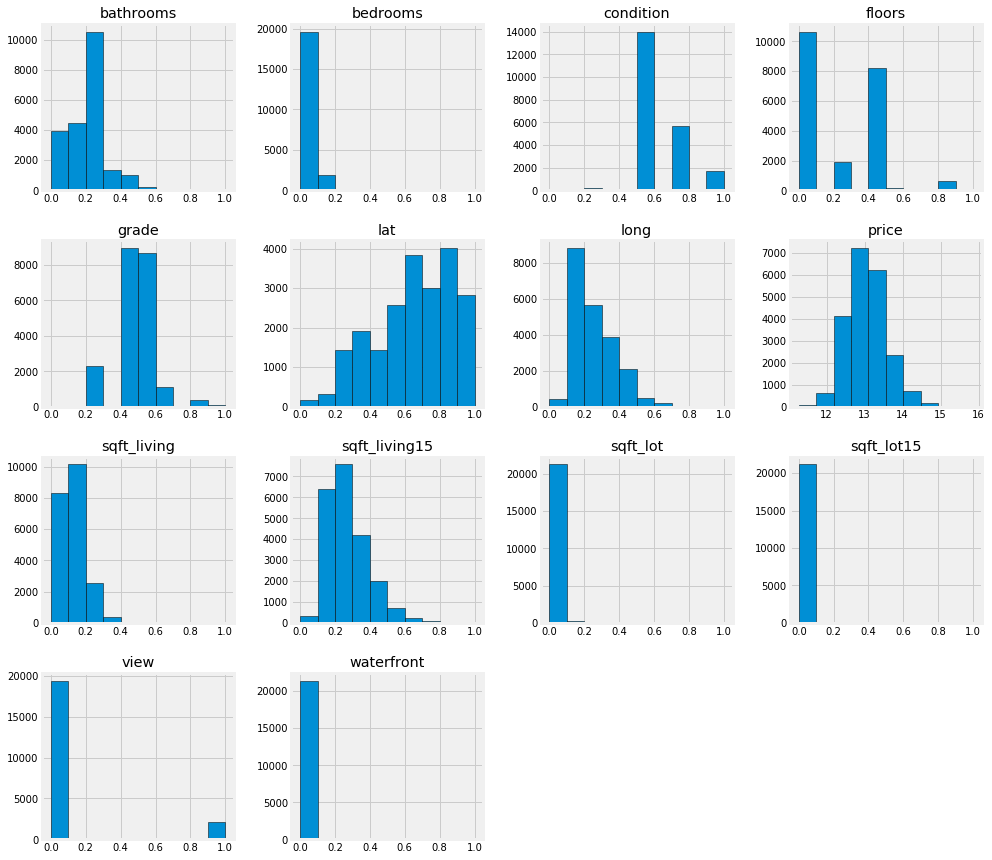

In [40]:
df_3.hist(figsize=(15,15), edgecolor = 'black');

In [41]:
# Feature ranking with Recursive Feature Elimination
from sklearn.feature_selection import RFE

predictors = df_3.drop('price', axis=1)

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 10)
selector = selector.fit(predictors, df_3['price'])

In [42]:
print(list(zip(predictors, selector.support_)))
print(list(zip(predictors, selector.ranking_)))

[('bedrooms', True), ('bathrooms', False), ('sqft_living', True), ('sqft_lot', True), ('floors', False), ('waterfront', True), ('view', False), ('condition', True), ('grade', True), ('lat', True), ('long', True), ('sqft_living15', True), ('sqft_lot15', True)]
[('bedrooms', 1), ('bathrooms', 2), ('sqft_living', 1), ('sqft_lot', 1), ('floors', 4), ('waterfront', 1), ('view', 3), ('condition', 1), ('grade', 1), ('lat', 1), ('long', 1), ('sqft_living15', 1), ('sqft_lot15', 1)]


In [43]:
#create a df with features from RFE
df_4 = df_3.drop(df_3[['bathrooms', 'floors', 'view']], axis=1)

In [44]:
linreg_summary(df_4)

R^2: 0.7423308577445277
MSE: 0.07183270109024627
RMSE: 0.26801623288570836
MAE: 0.21025082302981535
TRAIN_MAE: 0.21072266247601373


In [45]:
ols_linreg_summary(df_4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     6112.
Date:                Sat, 09 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:54:41   Log-Likelihood:                -2246.4
No. Observations:               21534   AIC:                             4515.
Df Residuals:                   21523   BIC:                             4603.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.1437      0.014    801.582      0.000      11.116      11.171
bedrooms         -0.2445      0.079     -3.079      0.002      -0.400      -0.089
sqft_living       2.5238      0.053     47.721      0.000       2.420       2.627
sqft_lot          0.9796      0.105      9.293      0.000       0.773       1.186
waterfront        0.6147      0.023     27.145      0.000       0.570       0.659
condition         0.3783      0.011     32.932      0.000       0.356       0.401
grade             1.4782      0.026     56.398      0.000       1.427       1.530
lat               0.9009      0.008    107.023      0.000       0.884       0.917
long             -0.3654      0.017    -21.049      0.000      -0.399      -0.331
sqft_living15     0.6467      0.026     24.927      0.000       0.596       0.698
sqft_lot15       -0.3042      0.085     -3.573      0.000      -0.471      -0.137
==============================================================================
Omnibus:                      225.110   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              336.412
Skew:                           0.111   Prob(JB):                     8.89e-74
Kurtosis:                       3.570   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

CV 5-Fold MAE: 0.21104806840462312
CV 10-Fold MAE: 0.21100783496726291
CV 20-Fold MAE: 0.21089251550813604


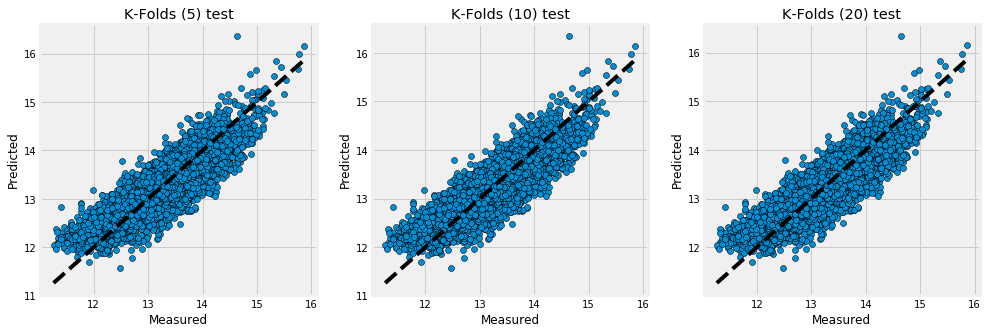

In [46]:
k_folds_cv(df_4)

**Observations:**
- Error metrics have reduced.


---

**Next Model:**
- Create map displaying locations of houses by price
- Incorporate location data using haversine to show distance to economic hub  
- Create column that incorporate distance to economic hubs 

---

**Visualize House Prices based on location**

In [47]:
print(df['price'].min())
print(df['price'].max())
print(df['price'].mean())
print(df['price'].median())

78000.0
7700000.0
540057.663833937
450000.0


Text(0.5, 0, 'longitude')

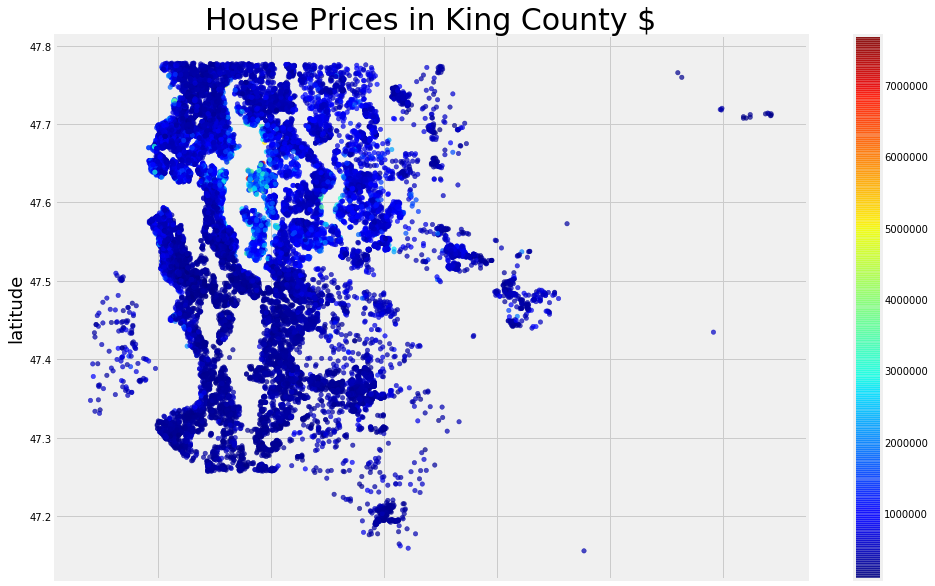

In [48]:
#where are these expensive houses located?
df.plot(kind='scatter', x='long', y='lat', 
            c=df['price'], 
            cmap=plt.get_cmap("jet"), 
            colorbar=True,
            alpha=0.7, 
            figsize=(15, 10))
plt.title('House Prices in King County $', fontsize=30)
plt.ylabel('latitude',fontsize=18)
plt.xlabel('longitude', fontsize=18)

**Observations:**
- Expensive houses appear to be mostly around downtown Seattle.
- Creating a column that consists the distance from Seattle seems logical.

In [49]:
#create 'lat_long' column as tuple for use in haversine formula
df_4['lat_long'] = list(zip(df['lat'], df['long']))

df_4.head()

,bedrooms,sqft_living,sqft_lot,waterfront,condition,grade,lat,long,sqft_living15,sqft_lot15,price,lat_long
0,0.06250,0.061503,0.003108,0.0,0.5,0.4,0.571498,0.217608,0.161934,0.005742,12.309982,"(47.5112, -122.257)"
1,0.06250,0.167046,0.004072,0.0,0.5,0.4,0.908959,0.166113,0.222165,0.008027,13.195614,"(47.721000000000004, -122.319)"
2,0.03125,0.030372,0.005743,0.0,0.5,0.3,0.936143,0.237542,0.399415,0.008513,12.100712,"(47.7379, -122.23299999999999)"
3,0.09375,0.120729,0.002714,0.0,1.0,0.4,0.586939,0.104651,0.165376,0.004996,13.311329,"(47.5208, -122.39299999999999)"
4,0.06250,0.099468,0.004579,0.0,0.5,0.5,0.741354,0.393688,0.241094,0.007871,13.142166,"(47.6168, -122.045)"


In [50]:
#set lat and long for seattle 
seattle = (47.608013,-122.335167)

#create column using haversine function
df_4['dist_to_sea'] = df_4['lat_long'].apply(lambda x: haversine(seattle, x, unit=Unit.MILES))

df_4.head()

,bedrooms,sqft_living,sqft_lot,waterfront,condition,grade,lat,long,sqft_living15,sqft_lot15,price,lat_long,dist_to_sea
0,0.06250,0.061503,0.003108,0.0,0.5,0.4,0.571498,0.217608,0.161934,0.005742,12.309982,"(47.5112, -122.257)",7.617592
1,0.06250,0.167046,0.004072,0.0,0.5,0.4,0.908959,0.166113,0.222165,0.008027,13.195614,"(47.721000000000004, -122.319)",7.842822
2,0.03125,0.030372,0.005743,0.0,0.5,0.3,0.936143,0.237542,0.399415,0.008513,12.100712,"(47.7379, -122.23299999999999)",10.155421
3,0.09375,0.120729,0.002714,0.0,1.0,0.4,0.586939,0.104651,0.165376,0.004996,13.311329,"(47.5208, -122.39299999999999)",6.601563
4,0.06250,0.099468,0.004579,0.0,0.5,0.5,0.741354,0.393688,0.241094,0.007871,13.142166,"(47.6168, -122.045)",13.529254


In [51]:
#create new df 
df_5 = df_4.drop('lat_long', axis=1)

In [52]:
#min-max scale 'dist_to_sea' column
df_5['dist_to_sea'] = (df_5['dist_to_sea'] - df_5['dist_to_sea'].min())/(df_5['dist_to_sea'].max() - df_5['dist_to_sea'].min())

df_5.head()

,bedrooms,sqft_living,sqft_lot,waterfront,condition,grade,lat,long,sqft_living15,sqft_lot15,price,dist_to_sea
0,0.06250,0.061503,0.003108,0.0,0.5,0.4,0.571498,0.217608,0.161934,0.005742,12.309982,0.144934
1,0.06250,0.167046,0.004072,0.0,0.5,0.4,0.908959,0.166113,0.222165,0.008027,13.195614,0.149701
2,0.03125,0.030372,0.005743,0.0,0.5,0.3,0.936143,0.237542,0.399415,0.008513,12.100712,0.198638
3,0.09375,0.120729,0.002714,0.0,1.0,0.4,0.586939,0.104651,0.165376,0.004996,13.311329,0.123434
4,0.06250,0.099468,0.004579,0.0,0.5,0.5,0.741354,0.393688,0.241094,0.007871,13.142166,0.270032


In [53]:
linreg_summary(df_5)

R^2: 0.7878482561620151
MSE: 0.05914341417638188
RMSE: 0.24319419026033884
MAE: 0.18680078577669287
TRAIN_MAE: 0.18918764147608522


In [54]:
ols_linreg_summary(df_5)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     7122.
Date:                Sat, 09 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:54:46   Log-Likelihood:                -208.18
No. Observations:               21534   AIC:                             440.4
Df Residuals:                   21522   BIC:                             536.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.5946      0.014    809.269      0.000      11.567      11.623
bedrooms         -0.2115      0.072     -2.929      0.003      -0.353      -0.070
sqft_living       2.4842      0.048     51.630      0.000       2.390       2.578
sqft_lot          1.1824      0.096     12.324      0.000       0.994       1.370
waterfront        0.6316      0.021     30.659      0.000       0.591       0.672
condition         0.3424      0.010     32.719      0.000       0.322       0.363
grade             1.3789      0.024     57.719      0.000       1.332       1.426
lat               0.4200      0.010     40.008      0.000       0.399       0.441
long              0.6951      0.022     31.078      0.000       0.651       0.739
sqft_living15     0.6327      0.024     26.805      0.000       0.586       0.679
sqft_lot15        0.1590      0.078      2.044      0.041       0.007       0.311
dist_to_sea      -1.4959      0.022    -66.972      0.000      -1.540      -1.452
==============================================================================
Omnibus:                      459.430   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1018.384
Skew:                          -0.039   Prob(JB):                    7.26e-222
Kurtosis:                       4.062   Cond. No.                         102.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

CV 5-Fold MAE: 0.18911483461199713
CV 10-Fold MAE: 0.18911311979508327
CV 20-Fold MAE: 0.18899259728854184


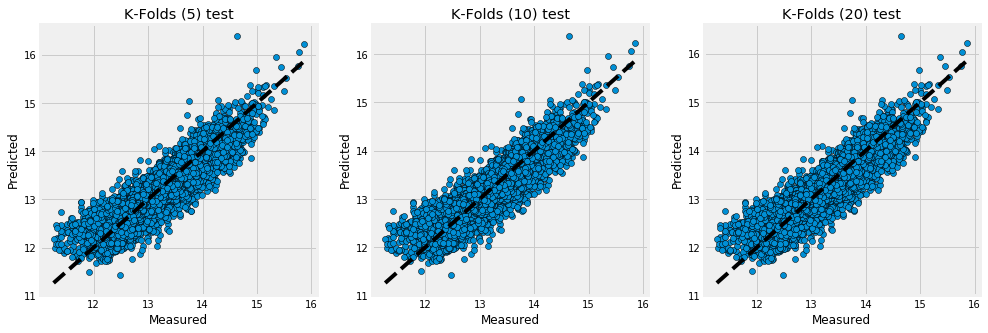

In [55]:
k_folds_cv(df_5)

**Next Steps**
- Try different combinations of features using RFE 
- Create predicting function with final selected features

In [56]:
predictors = df_5.drop('price', axis=1)

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 10)
selector = selector.fit(predictors, df_5['price'])

In [57]:
print(list(zip(predictors, selector.support_)))
print(list(zip(predictors, selector.ranking_)))

[('bedrooms', True), ('sqft_living', True), ('sqft_lot', True), ('waterfront', True), ('condition', True), ('grade', True), ('lat', True), ('long', True), ('sqft_living15', True), ('sqft_lot15', False), ('dist_to_sea', True)]
[('bedrooms', 1), ('sqft_living', 1), ('sqft_lot', 1), ('waterfront', 1), ('condition', 1), ('grade', 1), ('lat', 1), ('long', 1), ('sqft_living15', 1), ('sqft_lot15', 2), ('dist_to_sea', 1)]


In [58]:
df_6 = df_5.drop('sqft_lot15', axis=1)

In [59]:
linreg_summary(df_6)

R^2: 0.7877374051992567
MSE: 0.059174317077690476
RMSE: 0.2432577174062325
MAE: 0.18683623003356975
TRAIN_MAE: 0.1891971089151596


In [60]:
ols_linreg_summary(df_6)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     7833.
Date:                Sat, 09 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:54:49   Log-Likelihood:                -210.27
No. Observations:               21534   AIC:                             442.5
Df Residuals:                   21523   BIC:                             530.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.5937      0.014    809.506      0.000      11.566      11.622
bedrooms         -0.2195      0.072     -3.044      0.002      -0.361      -0.078
sqft_living       2.4885      0.048     51.767      0.000       2.394       2.583
sqft_lot          1.3168      0.070     18.838      0.000       1.180       1.454
waterfront        0.6322      0.021     30.687      0.000       0.592       0.673
condition         0.3429      0.010     32.780      0.000       0.322       0.363
grade             1.3773      0.024     57.679      0.000       1.330       1.424
lat               0.4209      0.010     40.124      0.000       0.400       0.441
long              0.6954      0.022     31.091      0.000       0.652       0.739
sqft_living15     0.6355      0.024     26.967      0.000       0.589       0.682
dist_to_sea      -1.4918      0.022    -67.051      0.000      -1.535      -1.448
==============================================================================
Omnibus:                      455.729   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1008.251
Skew:                          -0.036   Prob(JB):                    1.15e-219
Kurtosis:                       4.058   Cond. No.                         71.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observations:**
- As I decrease features:
    - error metrics increases.
    - R^2 decreases.
    - Adjusted R^2 does not increase.

## Deployment

In [61]:
# I will use this df for predict function
df_wa_location = pd.read_csv('data/wa_location_data.csv', delimiter=';')
df_wa_location.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,98520,Aberdeen,WA,46.972965,-123.81923,-8,1,"46.972965,-123.81923"
1,98579,Rochester,WA,46.814438,-123.08647,-8,1,"46.814438,-123.08647"
2,98604,Battle Ground,WA,45.791345,-122.51789,-8,1,"45.791345,-122.51789"
3,98144,Seattle,WA,47.585770,-122.30081,-8,1,"47.58577,-122.30081"
4,98833,Mazama,WA,48.634796,-120.47681,-8,1,"48.634796,-120.47681"


In [62]:
df_6.head()

,bedrooms,sqft_living,sqft_lot,waterfront,condition,grade,lat,long,sqft_living15,price,dist_to_sea
0,0.06250,0.061503,0.003108,0.0,0.5,0.4,0.571498,0.217608,0.161934,12.309982,0.144934
1,0.06250,0.167046,0.004072,0.0,0.5,0.4,0.908959,0.166113,0.222165,13.195614,0.149701
2,0.03125,0.030372,0.005743,0.0,0.5,0.3,0.936143,0.237542,0.399415,12.100712,0.198638
3,0.09375,0.120729,0.002714,0.0,1.0,0.4,0.586939,0.104651,0.165376,13.311329,0.123434
4,0.06250,0.099468,0.004579,0.0,0.5,0.5,0.741354,0.393688,0.241094,13.142166,0.270032


In [63]:
#model for deployment 
#define x and y
y = df_6['price']
X = df_6.drop(['price'], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)


# Instantiate and fit model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [64]:
#statistics for final model
y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)
    
# R Squared score
r2 = r2_score(y_test, y_hat_test)
print(f"R^2: {r2}")

# Mean Squared Error
test_mse = mean_squared_error(y_test, y_hat_test)
print(f"MSE: {test_mse}")
    
# Root Mean Squared Error
test_rmse = np.sqrt(test_mse)
print(f"RMSE: {test_rmse}")
    
# Mean Absolute Error
test_mae = mean_absolute_error(y_test, y_hat_test)
print(f"MAE: {test_mae}")

R^2: 0.7877374051992567
MSE: 0.059174317077690476
RMSE: 0.2432577174062325
MAE: 0.18683623003356975


In [65]:
cv_5_results = np.mean(abs(cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")))
cv_10_results = np.mean(abs(cross_val_score(model, X, y, cv=10, scoring="neg_mean_absolute_error")))
cv_20_results = np.mean(abs(cross_val_score(model, X, y, cv=20, scoring="neg_mean_absolute_error")))
    
print(f"CV 5-Fold MAE: {cv_5_results}")
print(f"CV 10-Fold MAE: {cv_10_results}")
print(f"CV 20-Fold MAE: {cv_20_results}")

CV 5-Fold MAE: 0.1891303587291591
CV 10-Fold MAE: 0.1891057447087801
CV 20-Fold MAE: 0.1889950738862841


---

In [66]:
#for use in predict function
bedrooms_min, bedrooms_max = df['bedrooms'].min(), df['bedrooms'].max()
sqft_living_min, sqft_living_max = df['sqft_living'].min(), df['sqft_living'].max()
sqft_lot_min, sqft_lot_max = df['sqft_lot'].min(), df['sqft_lot'].max()
condition_min, condition_max = df['condition'].min(), df['condition'].max()
grade_min, grade_max = df['grade'].min(), df['grade'].max()
sqft_living15_min, sqft_living15_max = df['sqft_living15'].min(), df['sqft_living15'].max()
waterfront_min, waterfront_max = df['waterfront'].min(), df['waterfront'].max()
latitude_min, latitude_max = df['lat'].min(), df['lat'].max()
longitude_min, longitude_max = df['long'].min(), df['long'].max()
dist_to_sea_min, dist_to_sea_max = 0.7684838756763036, 48.025059110961045

In [67]:
#for use in predict function
def min_max_scale(x, x_min, x_max):
    """Return Min-Max scaled"""
    x_scaled = (x-x_min)/(x_max-x_min)
    return x_scaled

In [68]:
def predict_price(bedrooms,
                 sqft_living,
                 sqft_lot,
                 condition,
                 grade,
                 sqft_living15,
                 zipcode,
                 waterfront):
    
    """Return Predicted House Price"""
    
    latitude = df_wa_location.loc[df_wa_location['Zip'] == int(zipcode), ['Latitude']].values[0]
    longitude = df_wa_location.loc[df_wa_location['Zip'] == int(zipcode), ['Longitude']].values[0]
    
    coordinates = (latitude, longitude)
    
    seattle = (47.608013,-122.335167)
    dist_to_sea = haversine(seattle, coordinates, unit=Unit.MILES) 
    
    
    bedrooms_scaled = min_max_scale(bedrooms, bedrooms_min, bedrooms_max)
    sqft_living_scaled = min_max_scale(sqft_living, sqft_living_min, sqft_living_max)
    sqft_lot_scaled = min_max_scale(sqft_lot, sqft_lot_min, sqft_lot_max)
    condition_scaled = min_max_scale(condition, condition_min, condition_max)
    grade_scaled = min_max_scale(grade, grade_min, grade_max)
    sqft_living15_scaled = min_max_scale(sqft_living15, sqft_living15_min, sqft_living15_max)
    waterfront_scaled = min_max_scale(waterfront, waterfront_min, waterfront_max)
    latitude_scaled = min_max_scale(latitude, latitude_min, latitude_max)
    longitude_scaled = min_max_scale(longitude, longitude_min, longitude_max)
    dist_to_sea_scaled = min_max_scale(dist_to_sea, dist_to_sea_min, dist_to_sea_max)
    
    
    X = [[bedrooms_scaled, sqft_living_scaled, sqft_lot_scaled, 
          condition_scaled, grade_scaled, sqft_living15_scaled, 
          waterfront_scaled, latitude_scaled, longitude_scaled, 
          dist_to_sea_scaled]]
    
    predicted_price = np.exp(model.predict(X))
    print(round(float(predicted_price), 2))

In [69]:
predict_price(bedrooms=5,
                 sqft_living=2000,
                 sqft_lot=4000,
                 condition=4,
                 grade=6,
                 sqft_living15=1800,
                 zipcode=98125,
                 waterfront=0)

616210.81


---

**Future Work:**
- Incorporate location better, conduct more eda to discover other locations, other than downtown Seattle, that influence housing prices.

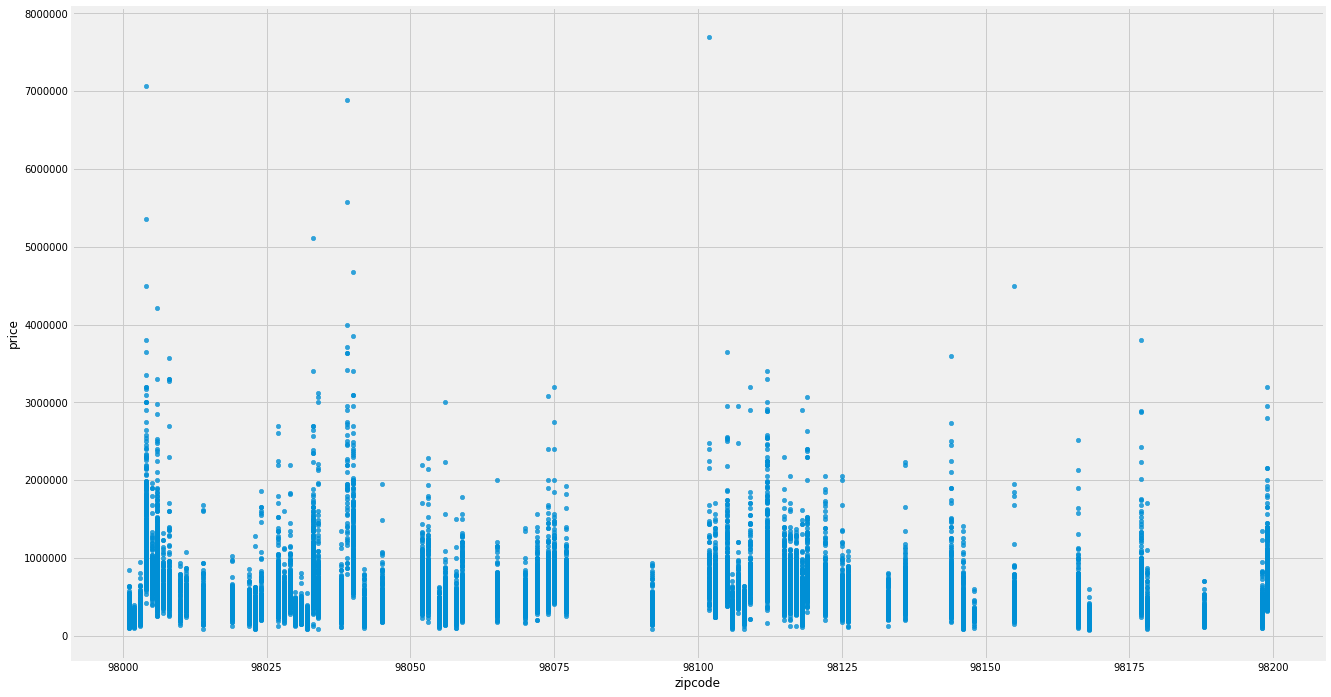

In [70]:
#display house prices based off zipcodes
df.plot(kind='scatter', x='zipcode', y='price', alpha=0.8, figsize=(20,12))
plt.show()

In [71]:
df_price_zip = df[['price','zipcode']]
df_price_zip.head()

,price,zipcode
0,221900.0,98178
1,538000.0,98125
2,180000.0,98028
3,604000.0,98136
4,510000.0,98074


In [72]:
df_hubs = df_price_zip.groupby(['zipcode']).mean()

In [74]:
df_hubs = df_hubs.sort_values(by=['price'])

In [75]:
#the zipcodes of the top ten most expensive areas measured by average price
df_hubs.tail(10)

,price
zipcode,
98005,8.102897e+05
98119,8.497148e+05
98006,8.601396e+05
98105,8.632289e+05
98109,8.800778e+05
98102,8.996077e+05
98112,1.094695e+06
98040,1.183231e+06
98004,1.358522e+06
